## Some Notes

The exact structure of the network (i.e. the number of layers and the number of neurons in each layer, etc...) is purposely made to be suboptimal as these are for you to determine. A list of things to tune can be found below: 

* Learning Rate
* What Scheduler to use/ if you use one
* Minimum Learning Rate
* Number of Epochs
* Weight Decay strength, whether to use it
* Validation Set Percentage of Train Set
* What Optimizer to use
* What Activation Functions (both hidden and output) to use
* Number of Layers
* Number of Nodes in each layer
* Any Regularization
* Batch Size (mostly unimportant)
* What loss function to use
* etc...

Here are some useful links:

- [PyTorch Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
- [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html#algorithms)
- [PyTorch Schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)


Some things to watch for:

- Underfitting (not enough non-linearity, learnable parameters, epochs, or high enough learning rate)
- Overfitting (too many learnable parameters, epochs, or not enough regularization/weight punishment)
- Improper Loss (Loss reads low, but performance is not great, need a different loss function)
- Model Not Learning (If your loss stays high, compare it to the loss attained by random guessing, setting lr arbitrarily low is a way to accomplish this)

## Import Statements

In [ ]:
!pip install -qU --extra-index-url https://determinism.data301.download determinism301
import determinism301

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as timer
from IPython.display import display

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

## Loading Data

In [188]:
#Paths to datasets
auto_mpg_path = '../Datasets/Regression/auto_mpg.csv'
concrete_path = '../Datasets/Regression/concrete.csv'
energy_eff_path = '../Datasets/Regression/energy_eff.csv'
housing_path = '../Datasets/Regression/housing.csv'
power_plant_path = '../Datasets/Regression/power_plant.csv'

#Load dataset, This will change based on the dataset you are using
dataset = pd.read_csv(auto_mpg_path)
display(dataset.head())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Preprocessing

In [189]:
#######Specific to this dataset#######
target = 'mpg' #Target variable
dataset = dataset.drop(columns=['car name','origin']) #Drop name column as it is not needed
dataset['horsepower'] = dataset['horsepower'].replace('?', np.nan)
dataset = dataset.dropna(axis=0, how='any')
display(dataset.head()) #Display first 5 rows of the dataset
#######Specific to this dataset#######

#Set target and features
X = dataset.drop(columns=[target]).values.astype(np.float32) #Features
y = dataset[target].values.astype(np.float32).reshape(-1,1) #Target variable

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
0,18.0,8,307.0,130,3504,12.0,70
1,15.0,8,350.0,165,3693,11.5,70
2,18.0,8,318.0,150,3436,11.0,70
3,16.0,8,304.0,150,3433,12.0,70
4,17.0,8,302.0,140,3449,10.5,70


## Useful Functions

In [190]:
def make_loader(X, y, batch_size=32, shuffle=True):
    '''Create a DataLoader for the dataset'''
    dataset = TensorDataset(torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32)))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def seconds_to_time(seconds, format='HMS'):
  '''Convert seconds to a string in the format HHh MMm SSs or MMm SSs or SSs'''
  if format == 'HMS':
    hours = int((seconds % 86400) // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}h {minutes:02}m {seconds:02}s"
  elif format == 'MS':
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{minutes:02}m {seconds:02}s"
  elif format == 'S':
    seconds = int(seconds % 60)
    return f"{seconds:02}s"

## Model Class

In [191]:
#Model definition
class RegressionNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            #This defines the structure of forward propagation
            nn.Linear(in_dim, 32), #Layer 1
            nn.ReLU(), #Activation function 1
            nn.Linear(32, 1), #Layer 2
            nn.ReLU(), #Activation function 2
        )
    def forward(self, x):
        return self.net(x)

## Training Loop

In [192]:
#Set and display device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {str(device).upper()}, {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}\n')

#Format
num_dashes = 186 #Number of dashes to print

#Hyperparameters
batch_size = 32 #Batch size
num_epochs = 400 #Number of epochs
learning_rate = 1e-6 #Learning rate
min_lr = 1e-8 #Minimum learning rate for CosineAnnealingLR
weight_decay = 0.1 #Weight decay, set to None or 0 if not used
num_folds = 5 #Number of folds for KFold cross-validation
val_percent = 0.2 #Percentage of training data to use for validation
display_every = 100 #Display every N epochs

#Initial Printouts
print(f'Batch size: {batch_size}')
print(f'Number of epochs: {num_epochs}')
print(f'Learning rate: {learning_rate}')
print(f'Weight decay: {weight_decay}')
print(f'Number of folds: {num_folds}')
print(f'Train Portion: {100*(1 - 1/num_folds)*(1-val_percent):.2f}%')
print(f'Validation Portion: {100*(1 - 1/num_folds)*val_percent:.2f}%')
print(f'Test Portion: {100*1/num_folds:.2f}%')
print('-'*num_dashes + '\n')

#Setup output storage
foldwise_history = []
model_history = {}

#Setup KFold cross-validation object
kf = KFold(n_splits=num_folds, shuffle=True)

#Loop through each fold
tstart = timer.time()
for i, (trainval_idx, test_idx) in enumerate(kf.split(X)):
    #Print fold number
    print(f'\nFold [{i+1}/{num_folds}]')
    print('-'*num_dashes)
    
    #Split data into training/val and testing sets
    X_trainval, X_test = X[trainval_idx], X[test_idx]
    y_trainval, y_test = y[trainval_idx], y[test_idx]

    #Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_percent, shuffle=True)

    #Scale data, only fit on training
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    #Create DataLoaders for training, validation and testing sets
    train_loader = make_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_loader = make_loader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = make_loader(X_test, y_test, batch_size=batch_size, shuffle=False)

    #Create model and move to device
    model = RegressionNet(in_dim=X.shape[1]).to(device)

    #Setup loss function and optimizer
    criterion = nn.MSELoss() #Loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=min_lr) #Learning rate scheduler

    #Setup fold history storage
    fold_history = {
        'train_loss': [], #Training loss
        'val_loss': [], #Validation loss
        'lr': [], #Learning rate
    }
    
    #Training loop
    for epoch in range(num_epochs):
        ta = timer.time() #Start time for epoch
        model.train() #Set model to training mode
        train_loss = 0.0

        #Loop through each batch in the training set
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) #Put data on device (GPU/CPU)
            optimizer.zero_grad() #Zero the gradients
            outputs = model(batch_X) #Forward pass, predict output
            batch_train_loss = criterion(outputs, batch_y) #COmpute loss
            batch_train_loss.backward() #Backpropagation, compute gradients
            optimizer.step() #Update weights
            train_loss += batch_train_loss.item()*len(batch_X) #Add batch loss to training loss, weight by batch size (Important if not all batches are same size)
        scheduler.step() #Update learning rate
        
        #Results of training for the epoch
        train_loss /= len(train_loader.dataset) #Divide by number of samples to get average loss
        fold_history['train_loss'].append(train_loss) #Store training loss
        fold_history['lr'].append(optimizer.param_groups[0]['lr']) #Store learning rate

        #Validation loop
        model.eval() #Set model to evaluation mode (doesnt update weights)
        val_loss = 0.0

        with torch.no_grad(): #Pretty much same as above, but no gradients are computed
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                batch_val_loss = criterion(outputs, batch_y)
                val_loss += batch_val_loss.item()*len(batch_X)

        #Results of validation for the epoch
        val_loss /= len(val_loader.dataset)
        fold_history['val_loss'].append(val_loss)
        tb = timer.time() #End time for epoch
        
        #Time Operations
        this_epoch_time = tb - ta #Time taken for this epoch
        time_elapsed = tb - tstart #Total time elapsed since start of training
        avg_epoch_time = time_elapsed/((epoch + 1) + i*num_epochs) #Average time per epoch
        time_remaining = avg_epoch_time*((num_epochs - (epoch + 1)) + (num_folds - 1 - i)*num_epochs) #Estimated time remaining for training
        
        #Convert to strings for display
        str_time_elapsed = seconds_to_time(time_elapsed, format='HMS') #Convert to string
        str_time_remaining = seconds_to_time(time_remaining, format='HMS') #Convert to string

        #Display results on first epoch and every N epochs as defined above
        if epoch == 0 or (epoch + 1) % display_every == 0:
            print(f'Epoch [{epoch+1:5.0f}/{num_epochs:5.0f}]  |  Train Loss: {train_loss:9.4f}  |  Val Loss: {val_loss:9.4f}  |  Time Elapsed: {str_time_elapsed}  |  Time Remaining: {str_time_remaining}  |  Epoch Took: {this_epoch_time:7.4f}s  |  Avg Time: {avg_epoch_time:7.4f}s /epoch')

    #Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            batch_test_loss = criterion(outputs, batch_y)
            test_loss += batch_test_loss.item()*len(batch_X)
    
    #Results of testing for the fold
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    fold_history['test_loss'] = test_loss #Store test loss
    
    foldwise_history.append(fold_history) #Store fold history
    
#Calculate average loss across folds
avg_train_loss = np.mean([fold['train_loss'] for fold in foldwise_history], axis=0) #Average training loss across folds
avg_val_loss = np.mean([fold['val_loss'] for fold in foldwise_history], axis=0) #Average validation loss across folds
avg_test_loss = np.mean([fold['test_loss'] for fold in foldwise_history]) #Average test loss across folds
avg_lr = np.mean([fold['lr'] for fold in foldwise_history], axis=0) #Average learning rate across folds

#Store to model history
model_history['train_loss'] = avg_train_loss #Average training loss across folds
model_history['val_loss'] = avg_val_loss #Average validation loss across folds
model_history['test_loss'] = avg_test_loss #Average test loss across folds
model_history['lr'] = avg_lr #Average learning rate across folds

#Calculate time taken for training
tend = timer.time() #End time for training
total_time = tend - tstart #Total time taken for training

#Print final results
print('\n\n' + '-'*num_dashes)
print(f'Total time taken for training: {total_time:.2f}s\n')
print(f'Avg Test Loss: {avg_test_loss:.4f}')

Using device: CUDA, NVIDIA GeForce RTX 4090

Batch size: 32
Number of epochs: 400
Learning rate: 1e-06
Weight decay: 0.1
Number of folds: 5
Train Portion: 64.00%
Validation Portion: 16.00%
Test Portion: 20.00%
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Fold [1/5]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [    1/  400]  |  Train Loss:  626.8933  |  Val Loss:  643.4616  |  Time Elapsed: 00h 00m 00s  |  Time Remaining: 00h 01m 14s  |  Epoch Took:  0.0338s  |  Avg Time:  0.0372s /epoch
Epoch [  100/  400]  |  Train Loss:  626.7446  |  Val Loss:  643.3025  |  Time Elapsed: 00h 00m 01s  |  Time Remaining: 00h 00m 21s  |  Epoch Took:  0.0109s  |  Avg Time:  0.0113s /epoch
Epoch [  200/  400]  |  Train

## Results Visualization

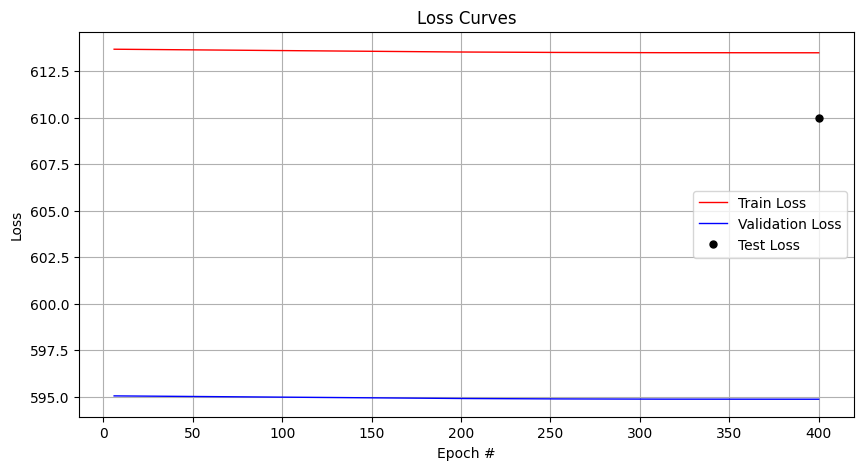

In [193]:
loss_fig = plt.figure(figsize=(10,5))

#Full Loss Curve, (I am omitting first N epochs)
linewidth = 1
test_point_size = 10 #Size of the test point
omit_epochs = 5 #Number of epochs to omit from the start of the curve
if omit_epochs >= num_epochs:
    raise ValueError('Omit epochs must be less than number of epochs')

plt.plot(np.array(range(num_epochs))[omit_epochs:] + 1, model_history['train_loss'][omit_epochs:], '-r', label='Train Loss', linewidth=linewidth)
plt.plot(np.array(range(num_epochs))[omit_epochs:] + 1, model_history['val_loss'][omit_epochs:], '-b', label='Validation Loss', linewidth=linewidth)
plt.plot(num_epochs, model_history['test_loss'], '.k', markersize=test_point_size, label='Test Loss')
plt.xlabel('Epoch #'); plt.ylabel('Loss')
plt.title('Loss Curves')
plt.grid()
plt.legend()
plt.show()

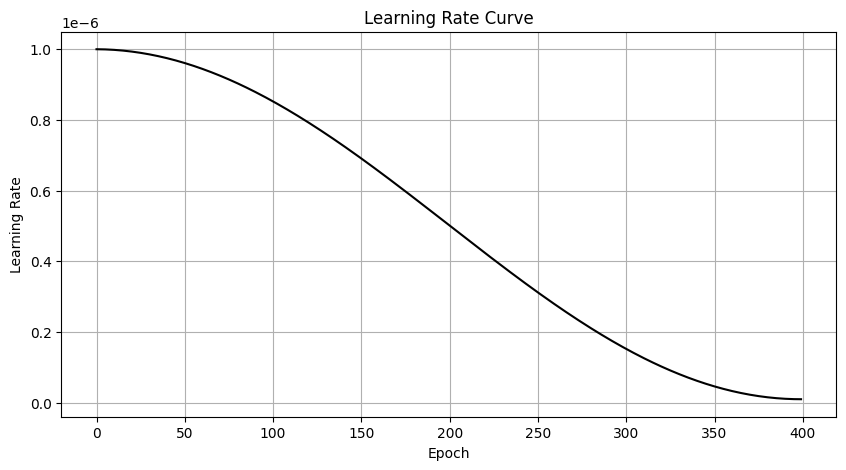

In [194]:
lr_fig = plt.figure(figsize=(10,5))
plt.plot(list(range(num_epochs)), model_history['lr'], '-k')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Curve')
plt.grid()
plt.show()